# SI 608 

### Data Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from fuzzywuzzy import process

/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
df = pd.read_csv("dblp_graph_conference_v12_new_author.csv")

In [8]:
df.isnull().sum()

index                    0
author_id                0
author_name              0
author_org           88826
id                       0
title                    0
year                     0
n_citation               0
doc_type                 0
reference_count          0
references          105536
venue_id                 0
venue_name               0
venue_type               0
doi                 157790
keyword                  0
volume              947805
issue              1037011
publisher                0
dtype: int64

In [ ]:
df["author_org"] = df["author_org"].fillna("unknown")



Missing doi's do not affect the data and are not filled

Volume and issue are also not filled since there are too many vacancies

In [15]:
df.isnull().sum()

index                    0
author_id                0
author_name              0
author_org               0
id                       0
title                    0
year                     0
n_citation               0
doc_type                 0
reference_count          0
references          105536
venue_id                 0
venue_name               0
venue_type               0
doi                 157790
keyword                  0
volume              947805
issue              1037011
publisher                0
dtype: int64

In [16]:
def clean_org(org):
    if "email" in org:
        org = org.rsplit(",", 1)[0]
    return org


df.loc[df["author_org"] == "nan", "author_org"] = "unknown"
df["author_org"] = df["author_org"].apply(
    lambda x: x.strip('"').replace("#TAB#", "").strip()
)

df["author_org"] = df["author_org"].apply(clean_org)

In [17]:
print(df["author_org"].value_counts())

author_org
unknown                                                                   153105
Carnegie - Mellon University                                                3996
Stanford, University                                                        2273
Carnegie-Mellon Univ., Pittsburgh, PA, USA                                  1954
Carnegie Mellon University, Pittsburgh Pa                                   1756
                                                                           ...  
IRIT-UPS, Toulouse Cedex, France                                               1
THALES Communications France, Colombes, France                                 1
LIRIS, Lyon 1 Univ., Lyon, France                                              1
INRP, ENS Cachan, Cachan, France                                               1
Archaeological Computing Research Group, University of Southampton, UK         1
Name: count, Length: 243247, dtype: int64


In [18]:
df["author_org"].isnull().sum()

np.int64(0)

#### Other paper related attributes

In [24]:
df.rename(columns={"author_org":"standard_org"}, inplace=True)

In [25]:
df["publisher"].value_counts()

publisher
IEEE                                                                                               376014
ACM                                                                                                164336
Springer, Berlin, Heidelberg                                                                       157110
unknown                                                                                            108753
Springer, Cham                                                                                      63753
                                                                                                    ...  
IEEE EMBS Int Conf Biomed Health Inform                                                                 1
The 26th International Conference on Software Engineering and Knowledge Engineering (SEKE 2014)         1
The 29th Pacific Asia Conference on Language, Information and Computation                               1
ACADEMIC PRESS LTD- ELSEVIER SCIENCE

In [27]:
df['venue_name'].value_counts()

venue_name
National Conference on Artificial Intelligence                                     15827
Computer Vision and Pattern Recognition                                            15516
International Conference on Acoustics, Speech, and Signal Processing               13433
International Conference on Robotics and Automation                                12741
International Conference on Image Processing                                       11525
                                                                                   ...  
International Symposium on Power Electronics for Distributed Generation Systems        1
IEEE International Conference on Circuits and Systems for Communications               1
European Conference on Radiation and Its Effects on Components and Systems             1
Self-Sustaining Systems                                                                1
International Conference on Software Technology and Engineering                        1
Name: coun

In [28]:
citation_grouped= df.groupby("author_id")['n_citation'].sum().reset_index(name="total_citation")
df=df.merge(citation_grouped, on="author_id", how="left")

paper_grouped= df.groupby("author_id")['index'].count().reset_index(name="total_paper")
df=df.merge(paper_grouped, on="author_id", how="left")

reference_grouped= df.groupby("author_id")['reference_count'].mean().reset_index(name="avg_reference")
df=df.merge(reference_grouped, on="author_id", how="left")



In [29]:
def merge_keywords(keywords):
    all_keywords = set()
    for kw in keywords:
        all_keywords.update(kw.split(';'))
    return all_keywords


author_keywords = df.groupby("author_id")["keyword"].apply(merge_keywords).reset_index(name='total_keyword')
df=df.merge(author_keywords, on="author_id", how="left")

### Split train and validation

In [114]:
most_recent_indices = df.groupby("author_id")["year"].idxmax()

valid = df.loc[most_recent_indices]

train = df.drop(most_recent_indices)

In [116]:
valid_author_ids = valid['author_id'].unique()
train_author_ids = train['author_id'].unique()

# Find authors present in train but not in valid
missing_from_valid = [author_id for author_id in train_author_ids if author_id not in valid_author_ids]
print("Authors in train but not in valid:", missing_from_valid)


Authors in train but not in valid: []


#### Build the graph

In [ ]:
G_train=nx.Graph()

In [ ]:

for index, row in train.iterrows():
    author_id = row['author_id']
    if not G_train.has_node(author_id):
        G_train.add_node(
            author_id,
            name=row['author_name'],
            org=row['standard_org'],
            total_citation=row["total_citation"], 
            total_paper=row["total_paper"],
            avg_reference=row["avg_reference"],     
            keywords=row["total_keyword"],   
        )


In [ ]:

for paper_id, group in train.groupby('id'):
    authors = group['author_id'].tolist()
    id = group['id'].iloc[0]
    title = group['title'].iloc[0]
    year = group['year'].iloc[0]
    venue_id = group['venue_id'].iloc[0]
    venue_name = group['venue_name'].iloc[0]
    publisher = group['publisher'].iloc[0]
    n_citation = group['n_citation'].iloc[0]  # 本篇文章的引用数

    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author1 = authors[i]
            author2 = authors[j]

            if G_train.has_edge(author1, author2):
                G_train[author1][author2]['papers'].append({
                    'id': id,
                    'title': title,
                    'year': year,
                    'venue_id': venue_id,
                    'venue_name': venue_name,
                    'publisher': publisher,
                    'n_citation': n_citation,  # 添加引用数
                })
            else:
                G_train.add_edge(author1, author2, papers=[{
                    'id': id,
                    'title': title,
                    'year': year,
                    'venue_id': venue_id,
                    'venue_name': venue_name,
                    'publisher': publisher,
                    'n_citation': n_citation,  # 添加引用数
                }])


### Network Analysis

In [35]:
print("# components: ",nx.number_connected_components(G_train))

nodes_num=len(G_train.nodes())
print('# nodes: ',nodes_num)

edges_num=len(G_train.edges())
print('# edge: ',edges_num)

largest_component = max(nx.connected_components(G_train), key=len)
percent_lc=round(len(largest_component)/nodes_num*100,2)
print("%_largest component: ",percent_lc)

# average degree
degree_dict=dict(nx.degree(G_train))
avg_d=sum(degree_dict.values())/len(G_train.nodes())
print("average degree: ",avg_d)

# average clustering coefficient
avg_cc=nx.average_clustering(G_train)
print("average clustering coefficient: ",avg_cc)

# components:  1095
# nodes:  29694
# edge:  153857
%_largest component:  94.4
average degree:  10.362834242607935
average clustering coefficient:  0.37782319359036604


### GNN 0

In [90]:
# tune
import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class TemporalAuthorGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TemporalAuthorGNN, self).__init__()
        # Time-series graph convolutional layer
        self.conv1 = pyg_nn.TAGConv(num_features, hidden_channels)
        self.conv2 = pyg_nn.TAGConv(hidden_channels, 1)  # The output layer predicts the number of citation
        
    def forward(self, x, edge_index, edge_attr):
        # First layer of graph convolution, using edge_attr to pass time information
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        
        # Second layer of graph convolution, outputting the predicted number of references
        x = self.conv2(x, edge_index, edge_attr)
        return x

def prepare_temporal_graph_data(train, valid):
    def calculate_h_index(citations):
     sorted_citations = sorted(citations, reverse=True)
     h_index = 0
     for i, cite_count in enumerate(sorted_citations, 1):
        if cite_count >= i:
            h_index = i
        else:
            break
     return h_index
    def extract_author_features(group):
        sorted_years = group.sort_values('year')
        citations = sorted_years['n_citation'].values
    
        # Citation increment: subsequent year minus previous year's citations
        citation_increments = [citations[i] - citations[i - 1] for i in range(1, len(citations))]
    
        return {
            'total_citation': group['n_citation'].sum(),
            'paper_count': len(group),
            'avg_citation': group['n_citation'].mean(),
            'min_year': group['year'].min(),
            'max_year': group['year'].max(),
            'h_index': calculate_h_index(group['n_citation']), 
            'citation_variance': group['n_citation'].var(), 
            'recent_citation_ratio': group[group['year'] > group['year'].max() - 3]['n_citation'].sum()/ group['n_citation'].sum(),
            'citation_increment': sum(citation_increments) / len(citation_increments) if citation_increments else 0
        }
    
    author_features = train.groupby('author_id').apply(extract_author_features)
    
    node_features = []
    node_ids = list(author_features.index)
    
    for node in node_ids:
        features = [
            author_features.loc[node]['total_citation'],
            author_features.loc[node]['paper_count'],
            author_features.loc[node]['avg_citation'],
            author_features.loc[node]['max_year'] - author_features.loc[node]['min_year'] + 1
        ]
        node_features.append(features)
    
    x = torch.tensor(node_features, dtype=torch.float)
    
    edges = []
    edge_attrs = []
    
    for paper_id, group in train.groupby('id'):
        authors = group['author_id'].tolist()
        year = group['year'].iloc[0]
        
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                author1 = authors[i]
                author2 = authors[j]
                
                edge = [node_ids.index(author1), node_ids.index(author2)]
                edges.append(edge)
                edges.append(edge[::-1])  # Add Reverse Edge
                
                # Side attributes use the year the paper was published
                edge_attrs.append([year])
                edge_attrs.append([year])
    
    # Converting Edges and Edge Properties
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    return x, edge_index, edge_attr, node_ids
    


In [91]:
# tune
class TemporalAuthorGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TemporalAuthorGNN, self).__init__()
        # Add more layers and dropout
        self.conv1 = pyg_nn.TAGConv(num_features, hidden_channels)
        self.conv2 = pyg_nn.TAGConv(hidden_channels, hidden_channels//2)
        self.conv3 = pyg_nn.TAGConv(hidden_channels//2, 1)
        
        # Add batch normalization and dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels//2)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_attr)
        return x

In [92]:
# tune
def train_and_evaluate_temporal_gnn(train, valid):
    # Learning Rate Scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-4
    )
    # early stopping
    early_stopping_patience = 20
    no_improvement_epochs = 0

    for epoch in range(100):
        # training
        if mae >= best_mae:
            no_improvement_epochs += 1
            if no_improvement_epochs > early_stopping_patience:
                print("Early stopping triggered")
                break
        else:
            no_improvement_epochs = 0

        lr_scheduler.step(mae)

In [93]:
# tune
def cross_validation(train_data):
    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True)
    
    all_metrics = []
    for train_index, val_index in kf.split(train_data):
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]
        
        model, predictions, metrics = train_and_evaluate_temporal_gnn(train_fold, val_fold)
        all_metrics.append(metrics)

    # Average Metrics
    avg_metrics = {
        'mse': np.mean([m['mse'] for m in all_metrics]),
        'mae': np.mean([m['mae'] for m in all_metrics]),
        'r2': np.mean([m['r2'] for m in all_metrics])
    }

/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/152240381.py:53: RuntimeWarning: invalid value encountered in scalar divide
  'recent_citation_ratio': group[group['year'] > group['year'].max() - 3]['n_citation'].sum()/ group['n_citation'].sum(),
/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/152240381.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  author_features = train.groupby('author_id').apply(extract_author_features)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likel

Epoch 0:
MSE Loss: 445.3655
MAE: 4.2005
R2 Score: -0.0317
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 10:
MSE Loss: 436.3144
MAE: 4.6753
R2 Score: -0.0154
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 20:
MSE Loss: 433.3614
MAE: 5.2509
R2 Score: -0.0177
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 30:
MSE Loss: 431.8066
MAE: 5.6734
R2 Score: -0.0088
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 40:
MSE Loss: 430.8446
MAE: 5.6505
R2 Score: 0.0012
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 50:
MSE Loss: 430.6040
MAE: 5.6913
R2 Score: 0.0001
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi


最终模型性能:
MSE: 429.3036
MAE: 5.8410
R2 Score: 0.0025


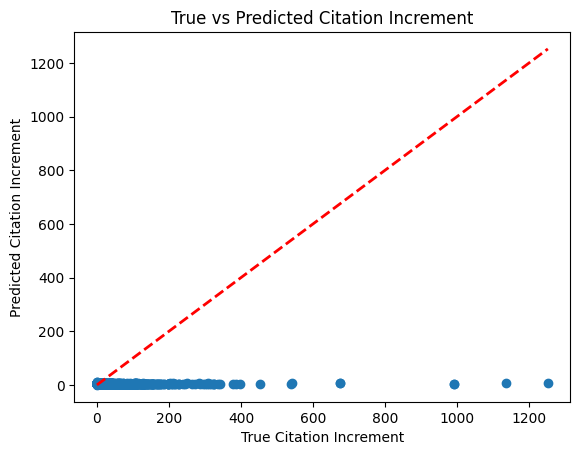

In [122]:

def train_and_evaluate_temporal_gnn(train, valid):
    # prepare data
    x, edge_index, edge_attr, node_ids = prepare_temporal_graph_data(train, valid)
    
    # define model
    num_features = x.shape[1]
    hidden_channels = 64
    
    # Initialization Model
    model = TemporalAuthorGNN(num_features, hidden_channels)
    
    # Loss Functions and Optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mse_criterion = torch.nn.MSELoss()
    
    # Prepare validation set target values
    valid_author_ids = valid['author_id'].unique()
    valid_targets = []
    valid_indices = []
    
    for author_id in valid_author_ids:
        author_index = node_ids.index(author_id)
        valid_target = valid[valid['author_id'] == author_id]['n_citation'].values[0]
        
        valid_targets.append(valid_target)
        valid_indices.append(author_index)
    
    valid_targets = torch.tensor(valid_targets, dtype=torch.float)
    
    # training cycle
    model.train()
    best_mae = float('inf')
    best_model = None
    
    for epoch in range(60):
        optimizer.zero_grad()
        
        # Forward Pass
        predictions = model(x, edge_index, edge_attr)
        
        # Calculate Loss
        loss = mse_criterion(predictions[valid_indices], valid_targets)
        
        # Backward Pass
        loss.backward()
        optimizer.step()
        
        # Evaluation
        with torch.no_grad():
            model.eval()
            pred_values = predictions[valid_indices].numpy()
            true_values = valid_targets.numpy()
            
            # Calculate Metrics
            mae = mean_absolute_error(true_values, pred_values)
            r2 = r2_score(true_values, pred_values)
            
            # Save the best model
            if mae < best_mae:
                best_mae = mae
                best_model = model.state_dict().copy()
            
            # Print Metrics
            if epoch % 10 == 0:
                print(f'Epoch {epoch}:')
                print(f'MSE Loss: {loss.item():.4f}')
                print(f'MAE: {mae:.4f}')
                print(f'R2 Score: {r2:.4f}')
                print('-' * 30)
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Final Evaluation
    model.eval()
    with torch.no_grad():
        final_predictions = model(x, edge_index, edge_attr)[valid_indices].numpy()
        final_true_values = valid_targets.numpy()
        
        final_mse = mean_squared_error(final_true_values, final_predictions)
        final_mae = mean_absolute_error(final_true_values, final_predictions)
        final_r2 = r2_score(final_true_values, final_predictions)
        
        print("\nfinal_model:")
        print(f"MSE: {final_mse:.4f}")
        print(f"MAE: {final_mae:.4f}")
        print(f"R2 Score: {final_r2:.4f}")
    
    plt.scatter(final_true_values, final_predictions)
    plt.plot([final_true_values.min(), final_true_values.max()], 
            [final_true_values.min(), final_true_values.max()], 
            'r--', lw=2)
    plt.xlabel("True Citation Increment")
    plt.ylabel("Predicted Citation Increment")
    plt.title("True vs Predicted Citation Increment")

    plt.show()
    
    return model, final_predictions, {
        'mse': final_mse,
        'mae': final_mae,
        'r2': final_r2
    }

model, predictions, metrics = train_and_evaluate_temporal_gnn(train, valid)

In [80]:
predictions.shape

(29694, 1)

In [98]:
print(predictions)

[[3.6793044]
 [4.027608 ]
 [4.2797637]
 ...
 [4.0865855]
 [3.7077227]
 [4.4538975]]


20%阈值准确率: 0.0526
10%阈值准确率: 0.0284


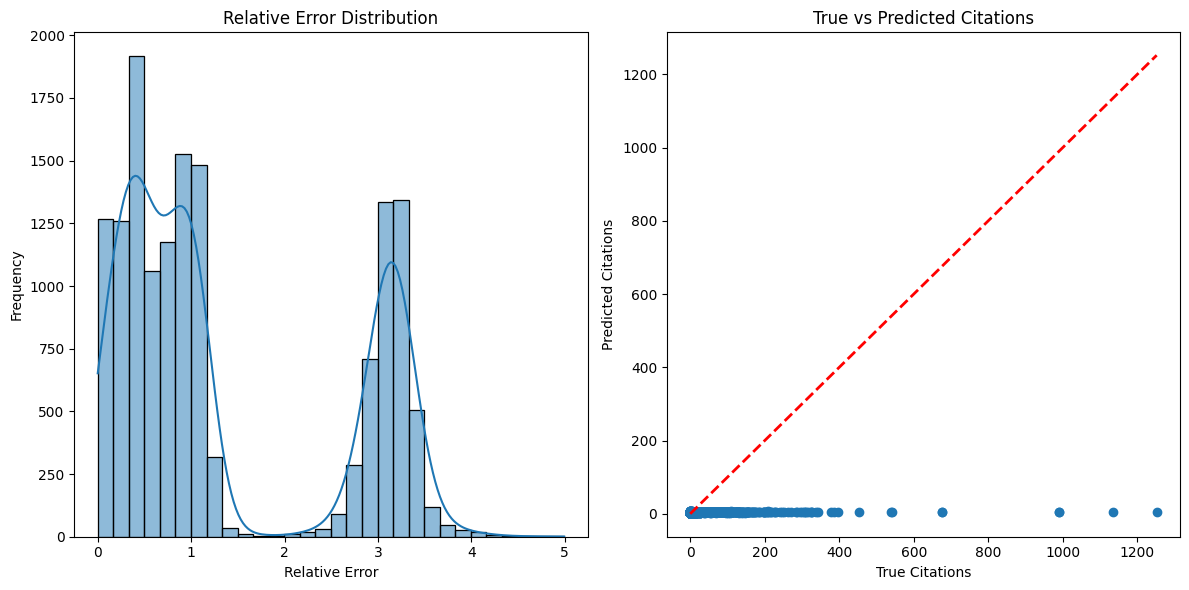

Accuracy_10.0%: 0.0284
Mean_Error_10.0%: 0.0424
Count_10.0%: 844.0000
Accuracy_20.0%: 0.0526
Mean_Error_20.0%: 0.0946
Count_20.0%: 1563.0000
Accuracy_30.0%: 0.0723
Mean_Error_30.0%: 0.1384
Count_30.0%: 2146.0000
Accuracy_50.0%: 0.1497
Mean_Error_50.0%: 0.2718
Count_50.0%: 4446.0000


In [102]:
predictions_1d = predictions.reshape(-1)

predicted_citations_series = pd.Series(predictions_1d, index=valid.index)

valid_with_predictions = valid.copy()
valid_with_predictions['predicted_citations'] = predicted_citations_series

valid_with_predictions['relative_error'] = np.abs(
    valid_with_predictions['n_citation'] - valid_with_predictions['predicted_citations']
) / valid_with_predictions['n_citation']

def calculate_accuracy(df, threshold=0.2):
    accurate_predictions = df[df['relative_error'] <= threshold]
    accuracy = len(accurate_predictions) / len(df)
    return accuracy

accuracy_20percent = calculate_accuracy(valid_with_predictions, threshold=0.2)
accuracy_10percent = calculate_accuracy(valid_with_predictions, threshold=0.1)

print(f"20% threshold accuracy: {accuracy_20percent:.4f}")
print(f"10% threshold accuracy: {accuracy_10percent:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(valid_with_predictions['relative_error'], bins=30, kde=True)
plt.title('Relative Error Distribution')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.scatter(
    valid_with_predictions['n_citation'], 
    valid_with_predictions['predicted_citations']
)
plt.plot(
    [valid_with_predictions['n_citation'].min(), valid_with_predictions['n_citation'].max()],
    [valid_with_predictions['n_citation'].min(), valid_with_predictions['n_citation'].max()],
    'r--', 
    lw=2
)
plt.title('True vs Predicted Citations')
plt.xlabel('True Citations')
plt.ylabel('Predicted Citations')

plt.tight_layout()
plt.show()


def detailed_accuracy_analysis(df, thresholds=[0.1, 0.2, 0.3, 0.5]):
    accuracy_results = {}
    for threshold in thresholds:
        accuracy = calculate_accuracy(df, threshold)
        accuracy_results[f'Accuracy_{threshold*100}%'] = accuracy
        
        accurate_predictions = df[df['relative_error'] <= threshold]
        accuracy_results[f'Mean_Error_{threshold*100}%'] = accurate_predictions['relative_error'].mean()
        accuracy_results[f'Count_{threshold*100}%'] = len(accurate_predictions)
    
    return accuracy_results

detailed_results = detailed_accuracy_analysis(valid_with_predictions)
for key, value in detailed_results.items():
    print(f"{key}: {value:.4f}")